# Feature level

In [1]:
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [2]:
import pandas as pd

df_train = pd.read_pickle('df_train_prep.p')
df_test = pd.read_pickle('df_test_prep.p')

In [3]:
#instantiate feature matrix and target vector for train set
features_train = df_train.drop("IsBadBuy", axis=1)
target_train = df_train.loc[:, "IsBadBuy"]

#for testing
features_train_copy = features_train.copy()

In [4]:
#class distribution
target_train.value_counts(normalize=True)

0    0.876158
1    0.123842
Name: IsBadBuy, dtype: float64

In [5]:
#instantiate feature matrix and target vector for test set
features_test = df_test.drop("IsBadBuy", axis=1)
target_test = df_test.loc[:, "IsBadBuy"]

In [6]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58373 entries, 0 to 58372
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   Auction                            58373 non-null  category
 1   VehicleAge                         58373 non-null  int64   
 2   Make                               58373 non-null  category
 3   Trim                               58373 non-null  category
 4   Color                              58373 non-null  category
 5   Transmission                       58373 non-null  category
 6   WheelType                          58373 non-null  category
 7   VehOdo                             58373 non-null  int64   
 8   Nationality                        58373 non-null  category
 9   Size                               58373 non-null  category
 10  TopThreeAmericanName               58373 non-null  category
 11  MMRAcquisitionAuctionAveragePrice  58373 

In [7]:
# baseline model: randomly predicting the same number of cases in each class
model_dummy = DummyClassifier(strategy='uniform', random_state=42)

cross_val_score(estimator=model_dummy,
                X=features_train, 
                y=target_train, 
                cv=3, 
                scoring='f1').mean()

0.19580426673003526

In [8]:
features_train.select_dtypes('category').nunique()

Auction                   3
Make                     33
Trim                    133
Color                    16
Transmission              2
WheelType                 3
Nationality               4
Size                     12
TopThreeAmericanName      4
BYRNO                    72
VNST                     37
IsOnlineSale              2
dtype: int64

In [9]:
features_train.loc[:, 'Transmission'].unique()

['AUTO', 'MANUAL']
Categories (2, object): ['AUTO', 'MANUAL']

In [10]:
# dummy coding
features_train.loc[:, 'Transmission'] = features_train.loc[:, 'Transmission'].replace({'AUTO':0, 'MANUAL':1})
features_train.loc[:, 'Transmission'] = features_train.loc[:, 'Transmission'].astype('category')

C:\Users\dk\AppData\Local\Temp\ipykernel_10880\1451359090.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features_train.loc[:, 'Transmission'] = features_train.loc[:, 'Transmission'].replace({'AUTO':0, 'MANUAL':1})
C:\Users\dk\AppData\Local\Temp\ipykernel_10880\1451359090.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features_train.loc[:, 'Transmission'] = features_train.loc[:, 'Transmission'].astype('category')


In [11]:
features_train.select_dtypes('category').columns

Index(['Auction', 'Make', 'Trim', 'Color', 'Transmission', 'WheelType',
       'Nationality', 'Size', 'TopThreeAmericanName', 'BYRNO', 'VNST',
       'IsOnlineSale'],
      dtype='object')

In [12]:
ohe_cols = ['Auction', 
            'Make',
            'Trim',
            'Color', 
            'WheelType',
            'Nationality', 
            'Size', 
            'TopThreeAmericanName', 
            'BYRNO', 
            'VNST']

In [13]:
features_train.select_dtypes('number').columns

Index(['VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice',
       'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice',
       'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice',
       'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice',
       'MMRCurrentRetailCleanPrice', 'VehBCost', 'WarrantyCost', 'PurchYear'],
      dtype='object')

In [14]:
num_cols = ['VehicleAge', 
            'VehOdo', 
            'MMRAcquisitionAuctionAveragePrice',
            'MMRAcquisitionAuctionCleanPrice', 
            'MMRAcquisitionRetailAveragePrice',
            'MMRAcquisitonRetailCleanPrice', 
            'MMRCurrentAuctionAveragePrice',
            'MMRCurrentAuctionCleanPrice', 
            'MMRCurrentRetailAveragePrice',
            'MMRCurrentRetailCleanPrice', 
            'VehBCost', 
            'WarrantyCost',
            'PurchYear']

In [15]:
num_cols = features_train.select_dtypes('category').columns

In [16]:
# one-hot encoding categorial columns and standardising mmr colums to handle high correlations
col_transformer = ColumnTransformer(transformers=[("OHE", 
                                                   OneHotEncoder(handle_unknown="ignore", 
                                                                 drop='first'), 
                                                   ohe_cols)],
                                    remainder="passthrough",
                                    sparse_threshold=0)

scaler = StandardScaler()

In [17]:
# simple model
from sklearn.linear_model import LogisticRegression

baseline_lr = LogisticRegression(class_weight="balanced",
                                 random_state=42,
                                 max_iter=1000)

pipe_base = Pipeline([("col_encoder", col_transformer),
                      ("scaler", scaler),
                      ("model", baseline_lr)])

pipe_base.fit(features_train, target_train)

cv_results = cross_validate(estimator=pipe_base, 
                            X=features_train, 
                            y=target_train, 
                            cv=5, 
                            scoring=['precision', 'recall', 'f1'])

C:\Users\dk\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\dk\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\dk\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\dk\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\dk\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unkn

In [18]:
cv_results

{'fit_time': array([3.08083987, 3.47083378, 3.05576229, 3.39761472, 2.94306183]),
 'score_time': array([0.06001019, 0.05802584, 0.05664015, 0.05867863, 0.05854273]),
 'test_precision': array([0.19845028, 0.19716727, 0.2021692 , 0.20292066, 0.20255434]),
 'test_recall': array([0.63762102, 0.60650069, 0.64453665, 0.64429066, 0.62517289]),
 'test_f1': array([0.30269206, 0.29759077, 0.30779392, 0.30863584, 0.30597394])}

In [19]:
print('precision: ', list(cv_results.values())[2].mean())
print('recall: ', list(cv_results.values())[3].mean())
print('f1: ', list(cv_results.values())[4].mean())

precision:  0.20065234832827042
recall:  0.6316243832167966
f1:  0.3045373046211116


In [20]:
# feature engineering

# calculating average prices of MMR prices
MMR_cols = ['MMRAcquisitionAuctionAveragePrice',
            'MMRAcquisitionAuctionCleanPrice',
            'MMRAcquisitionRetailAveragePrice',
            'MMRAcquisitonRetailCleanPrice',
            'MMRCurrentAuctionAveragePrice',
            'MMRCurrentAuctionCleanPrice',
            'MMRCurrentRetailAveragePrice',
            'MMRCurrentRetailCleanPrice']

features_train['AvgPrice'] = sum(features_train[col] for col in MMR_cols) / len(MMR_cols)

# calculating average prices of Auctions
MMR_auction = ['MMRAcquisitionAuctionAveragePrice',
               'MMRAcquisitionAuctionCleanPrice',
               'MMRCurrentAuctionAveragePrice',
               'MMRCurrentAuctionCleanPrice']

features_train['AvgPrice_Auction'] = sum(features_train[col] for col in MMR_auction) / len(MMR_auction)

# calculating average prices of Retails
MMR_retail = ['MMRAcquisitionAuctionAveragePrice',
              'MMRAcquisitionAuctionCleanPrice',
              'MMRCurrentAuctionAveragePrice',
              'MMRCurrentAuctionCleanPrice']

features_train['AvgPrice_Retail'] = sum(features_train[col] for col in MMR_retail) / len(MMR_retail)

In [21]:
#feature engineering function
def feature_engineering(features):
    """
    Engineers features and selects most important ones.

    Args:
        features (pd.DataFrame) : Feature matrix

    Returns:
        features (pd.DataFrame) : Selected feature matrix.
    """
    
    # dummy coding
    features.loc[:, 'Transmission'] = features.loc[:, 'Transmission'].replace({'AUTO':0, 'MANUAL':1})
    features.loc[:, 'Transmission'] = features.loc[:, 'Transmission'].astype('category')

    ohe_cols = ['Auction',
                'Make',
                'Trim',
                'Color',
                'WheelType',
                'Nationality',
                'Size',
                'TopThreeAmericanName',
                'BYRNO',
                'VNST']

    num_cols = ['VehicleAge',
                'VehOdo',
                'MMRAcquisitionAuctionAveragePrice',
                'MMRAcquisitionAuctionCleanPrice',
                'MMRAcquisitionRetailAveragePrice',
                'MMRAcquisitonRetailCleanPrice',
                'MMRCurrentAuctionAveragePrice',
                'MMRCurrentAuctionCleanPrice',
                'MMRCurrentRetailAveragePrice',
                'MMRCurrentRetailCleanPrice',
                'VehBCost',
                'WarrantyCost',
                'PurchYear']

    MMR_cols = ['MMRAcquisitionAuctionAveragePrice',
                'MMRAcquisitionAuctionCleanPrice',
                'MMRAcquisitionRetailAveragePrice',
                'MMRAcquisitonRetailCleanPrice',
                'MMRCurrentAuctionAveragePrice',
                'MMRCurrentAuctionCleanPrice',
                'MMRCurrentRetailAveragePrice',
                'MMRCurrentRetailCleanPrice']

    features['AvgPrice'] = sum(features[col] for col in MMR_cols) / len(MMR_cols)

    MMR_auction = ['MMRAcquisitionAuctionAveragePrice',
                   'MMRAcquisitionAuctionCleanPrice',
                   'MMRCurrentAuctionAveragePrice',
                   'MMRCurrentAuctionCleanPrice']
    features['AvgPrice_Auction'] = sum(features[col]
                                 for col in MMR_auction) / len(MMR_auction)

    MMR_retail = ['MMRAcquisitionAuctionAveragePrice',
                  'MMRAcquisitionAuctionCleanPrice',
                  'MMRCurrentAuctionAveragePrice',
                  'MMRCurrentAuctionCleanPrice']
    features['AvgPrice_Retail'] = sum(features[col]
                                for col in MMR_retail) / len(MMR_retail)

    return features

In [22]:
#test function
features_train_eng = feature_engineering(features_train_copy)
(features_train_eng.equals(features_train))

C:\Users\dk\AppData\Local\Temp\ipykernel_10880\2203189024.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features.loc[:, 'Transmission'] = features.loc[:, 'Transmission'].replace({'AUTO':0, 'MANUAL':1})
C:\Users\dk\AppData\Local\Temp\ipykernel_10880\2203189024.py:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features.loc[:, 'Transmission'] = features.loc[:, 'Transmission'].astype('category')


True

In [23]:
# dimensionality reduction
pca_col_transformer = ColumnTransformer(transformers=[("OHE", 
                                                       OneHotEncoder(handle_unknown="ignore", 
                                                                     drop='first'), 
                                                       ohe_cols),                                                      
                                                      ("PCA_MMR", 
                                                       PCA(n_components=1, 
                                                           random_state=42), 
                                                       MMR_cols)],
                                        remainder="passthrough",
                                        sparse_threshold=0)
                                         
base_pca_pipe = Pipeline([("col_encoder", pca_col_transformer),
                          ("scaler", scaler),
                          ("model", baseline_lr)])
                          
base_pca_pipe.fit(features_train, target_train)

cross_validate(estimator=pipe_base, X=features_train, y=target_train, cv=5, scoring=['precision', 'recall', 'f1'])

C:\Users\dk\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\dk\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\dk\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\dk\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\dk\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unkn

{'fit_time': array([3.40407634, 3.59428644, 4.15136766, 3.89281368, 3.17682981]),
 'score_time': array([0.05947948, 0.0580008 , 0.06306171, 0.06700325, 0.05951118]),
 'test_precision': array([0.19836489, 0.19730034, 0.20203772, 0.20300916, 0.20242098]),
 'test_recall': array([0.63762102, 0.60650069, 0.64453665, 0.64429066, 0.62448133]),
 'test_f1': array([0.30259271, 0.29774232, 0.30764153, 0.30873819, 0.30573895])}

In [24]:
print('precision: ', list(cv_results.values())[2].mean())
print('recall: ', list(cv_results.values())[3].mean())
print('f1: ', list(cv_results.values())[4].mean())

precision:  0.20065234832827042
recall:  0.6316243832167966
f1:  0.3045373046211116


In [25]:
# feature importance
result = permutation_importance(base_pca_pipe, features_train, target_train, random_state=42)
sorted_idx = result.importances_mean.argsort()

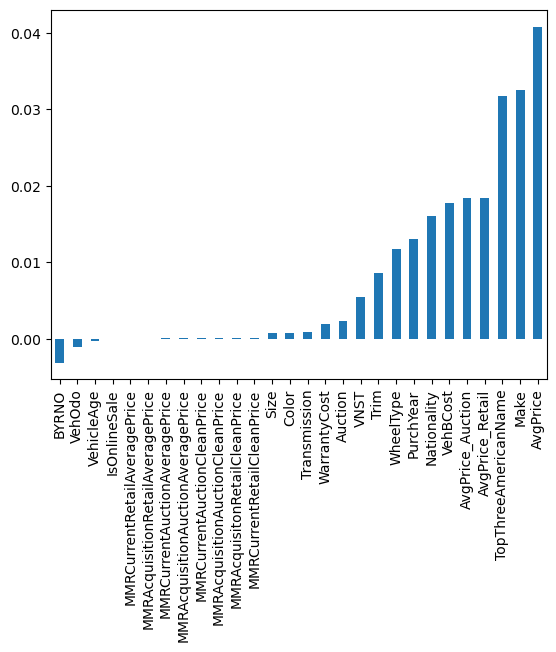

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pd.Series(data=result.importances_mean[sorted_idx].T,
          index=features_train.columns[sorted_idx]).plot.bar(ax=ax);

In [27]:
keep_cols = list(features_train.columns[sorted_idx][-12:])
print(keep_cols)

['Auction', 'VNST', 'Trim', 'WheelType', 'PurchYear', 'Nationality', 'VehBCost', 'AvgPrice_Auction', 'AvgPrice_Retail', 'TopThreeAmericanName', 'Make', 'AvgPrice']


In [28]:
remove_cols = [col for col in features_train.columns[sorted_idx] if col not in keep_cols]
print(remove_cols)

['BYRNO', 'VehOdo', 'VehicleAge', 'IsOnlineSale', 'MMRCurrentRetailAveragePrice', 'MMRAcquisitionRetailAveragePrice', 'MMRCurrentAuctionAveragePrice', 'MMRAcquisitionAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentRetailCleanPrice', 'Size', 'Color', 'Transmission', 'WarrantyCost']


In [29]:
features_train = features_train.drop(remove_cols, axis=1)

In [30]:
features_train.head()

,Auction,Make,Trim,WheelType,Nationality,TopThreeAmericanName,VNST,VehBCost,PurchYear,AvgPrice,AvgPrice_Auction,AvgPrice_Retail
0,MANHEIM,FORD,SEL,Alloy,AMERICAN,FORD,NC,8000.0,2009,13361.000,12606.75,12606.75
1,MANHEIM,GMC,SLE,Alloy,AMERICAN,GM,MD,7195.0,2009,8893.250,8310.75,8310.75
2,OTHER,DODGE,SE,Alloy,AMERICAN,CHRYSLER,OK,7300.0,2010,9785.625,8155.50,8155.50
3,OTHER,CHEVROLET,Bas,Covers,AMERICAN,GM,CO,5655.0,2009,4697.500,4276.50,4276.50
4,OTHER,HYUNDAI,GLS,Alloy,OTHER ASIAN,OTHER,AL,7900.0,2010,8595.500,6784.25,6784.25


# Algorithm level

In [31]:
# apply feature engineering function on test set
features_test = feature_engineering(features_test)
features_test = features_test.drop(remove_cols, axis=1)

C:\Users\dk\AppData\Local\Temp\ipykernel_10880\2203189024.py:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features.loc[:, 'Transmission'] = features.loc[:, 'Transmission'].replace({'AUTO':0, 'MANUAL':1})
C:\Users\dk\AppData\Local\Temp\ipykernel_10880\2203189024.py:15: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features.loc[:, 'Transmission'] = features.loc[:, 'Transmission'].astype('category')


In [32]:
ohe_cols = [col for col in ohe_cols if col not in remove_cols]

col_transformer = ColumnTransformer(transformers=[("OHE", OneHotEncoder(handle_unknown="ignore"), ohe_cols)],
                                    remainder="passthrough",
                                    sparse_threshold=0)

In [33]:
# logistic regression
model_lr = LogisticRegression(class_weight="balanced",
                              random_state=42,
                              max_iter=1000)

model_pipe_lr = Pipeline([("col_encoder", col_transformer),
                          ("scaler", scaler),
                          ("model", model_lr)])

search_grid_lr = {"model__C": [0.005, 0.01, 0.05, 1]}

grid_model_lr = GridSearchCV(estimator=model_pipe_lr,
                             param_grid=search_grid_lr,
                             cv=5,
                             scoring="f1")

grid_model_lr.fit(features_train, target_train)

print(grid_model_lr.best_estimator_)
print(grid_model_lr.best_score_)

Pipeline(steps=[('col_encoder',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('OHE',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Auction', 'Make', 'Trim',
                                                   'WheelType', 'Nationality',
                                                   'TopThreeAmericanName',
                                                   'VNST'])])),
                ('scaler', StandardScaler()),
                ('model',
                 LogisticRegression(C=0.005, class_weight='balanced',
                                    max_iter=1000, random_state=42))])
0.29904796842292136


In [34]:
target_test_pred = grid_model_lr.predict(features_test)
print(classification_report(target_test, target_test_pred))

              precision    recall  f1-score   support

           0       0.92      0.64      0.76     12846
           1       0.19      0.61      0.29      1746

    accuracy                           0.64     14592
   macro avg       0.55      0.62      0.52     14592
weighted avg       0.83      0.64      0.70     14592



In [35]:
# knn
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier()

# tune hyperparameters
model_pipe_knn = Pipeline([("col_encoder", col_transformer),
                           ("scaler", scaler),
                           ("model", model_knn)])

search_grid_knn = {"model__n_neighbors": range(1, 6),
                   "model__weights": ['uniform', 'distance']}

grid_model_knn = GridSearchCV(estimator=model_pipe_knn,
                              param_grid=search_grid_knn,
                              cv=5,
                              scoring="f1")

grid_model_knn.fit(features_train, target_train)

print(grid_model_knn.best_estimator_)
print(grid_model_knn.best_score_)

Pipeline(steps=[('col_encoder',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('OHE',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Auction', 'Make', 'Trim',
                                                   'WheelType', 'Nationality',
                                                   'TopThreeAmericanName',
                                                   'VNST'])])),
                ('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=1))])
0.20555210888182857


In [36]:
target_test_pred = grid_model_knn.predict(features_test)
print(classification_report(target_test, target_test_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89     12846
           1       0.19      0.19      0.19      1746

    accuracy                           0.81     14592
   macro avg       0.54      0.54      0.54     14592
weighted avg       0.81      0.81      0.81     14592



In [37]:
# decision tree
from sklearn.tree import DecisionTreeClassifier

model_dt = DecisionTreeClassifier(class_weight="balanced", random_state=42)

model_pipe_dt = Pipeline([("col_encoder", col_transformer),
                          ("model", model_dt)])

search_grid_dt = {"model__max_depth": range(1, 10)}

grid_model_dt = GridSearchCV(estimator=model_pipe_dt,
                             param_grid=search_grid_dt,
                             cv=5,
                             scoring="f1")

grid_model_dt.fit(features_train, target_train)

print(grid_model_dt.best_estimator_)
print(grid_model_dt.best_score_)

Pipeline(steps=[('col_encoder',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('OHE',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Auction', 'Make', 'Trim',
                                                   'WheelType', 'Nationality',
                                                   'TopThreeAmericanName',
                                                   'VNST'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5,
                                        random_state=42))])
0.2835253358504266


In [38]:
target_test_pred = grid_model_dt.predict(features_test)
print(classification_report(target_test, target_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.58      0.71     12846
           1       0.18      0.66      0.28      1746

    accuracy                           0.59     14592
   macro avg       0.55      0.62      0.50     14592
weighted avg       0.84      0.59      0.66     14592



In [39]:
# random forest
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(class_weight="balanced", 
                                  random_state=42,
                                  n_jobs=-1)

model_pipe_rf = Pipeline([("ohe", col_transformer),
                          ("model", model_rf)])

model_pipe_rf.fit(features_train, target_train)

cross_val_score(estimator=model_pipe_rf,
                X=features_train, 
                y=target_train, 
                cv=5, 
                scoring='f1').mean()

0.07834145179703708

In [40]:
target_test_pred = model_pipe_rf.predict(features_test)
print(classification_report(target_test, target_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93     12846
           1       0.35      0.05      0.09      1746

    accuracy                           0.88     14592
   macro avg       0.62      0.52      0.51     14592
weighted avg       0.82      0.88      0.83     14592



# Model selection and predictions

selecting model with best f1 score on test set (mostly bad f1 scores due to low precision)

In [41]:
# predictions on aim data
df_aim = pd.read_csv("test.csv")
target_aim_pred = grid_model_lr.predict(features_test)

In [42]:
# amount of cars that are good buys (0) or "lemons" (1) 
pd.Series(target_aim_pred).value_counts()

0    8922
1    5670
dtype: int64